### Importing TensorFlow and dependencies

In [24]:
%%time 
from __future__ import absolute_import, print_function, division, unicode_literals

import numpy as np
import pandas as pd

try:
  %tensorflow_version 2.x
  print("TensorFlow is up and running.")
except:
  print("TensorFlow NOT FOUND.")

import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

print("TensorFlow Version: ",tf.__version__)
print("Eager Execution Enabled: ",tf.executing_eagerly())
print("GPU is", "avaliable" if tf.test.is_gpu_available() else "not available")

import warnings
warnings.filterwarnings("ignore")

print("Done.!")

TensorFlow is up and running.
TensorFlow Version:  2.0.0-rc0
Eager Execution Enabled:  True
GPU is avaliable
Done.!
CPU times: user 5.93 ms, sys: 3 ms, total: 8.93 ms
Wall time: 13.3 ms


### Loading the Dataset

In [25]:
URL = 'https://storage.googleapis.com/applied-dl/heart.csv'
df_raw = pd.read_csv(URL)
df_raw.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [26]:
train, test = train_test_split(df_raw, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train),"Train Samples.")
print(len(test),"Test Samples.")
print(len(val),"Validation Samples.")

193 Train Samples.
61 Test Samples.
49 Validation Samples.


### Create an Input Pipeline using tf.data

Next, we will wrap the dataframes with tf.data. This will enable us to use feature columns as a bridge to map from the columns in the Pandas dataframe to features used to train the model. If we were working with a very large CSV file (so large that it does not fit into memory), we would use tf.data to read it from disk directly. That is not covered in this tutorial.

In [0]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe),labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [0]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [29]:
for feature_batch, label_batch in train_ds.take(1):
  print("Every feature: ", list(feature_batch.keys()))
  print("A batch of ages: ", feature_batch['age'])
  print("A batch of targets: ",label_batch)

Every feature:  ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
A batch of ages:  tf.Tensor([47 58 66 57 55], shape=(5,), dtype=int32)
A batch of targets:  tf.Tensor([0 0 1 0 1], shape=(5,), dtype=int32)


### Demonstrate several types of feature column

TensorFlow provides many types of feature columns. In this section, we will create several types of feature columns, and demonstrate how they transform a column from the dataframe.

In [0]:
example_batch = next(iter(train_ds))[0]

In [0]:
def demo(feature_column):
  feature_layer = layers.DenseFeatures(feature_column)
  print(feature_layer(example_batch).numpy())

#### Numeric Columns

In [32]:
age = feature_column.numeric_column("age")
demo(age)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[53.]
 [60.]
 [60.]
 [55.]
 [45.]]


#### Bucketized Columns

In [33]:
age_buckets = feature_column.bucketized_column(age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
demo(age_buckets)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


#### Categorical Columns

In [34]:
thal = feature_column.categorical_column_with_vocabulary_list(
    'thal', ['fixed','normal','reversible']
)

thal_one_hot = feature_column.indicator_column(thal)

demo(thal_one_hot)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]


#### Embedding Column

In [35]:
thal_embedding = feature_column.embedding_column(thal,dimension=8)
demo(thal_embedding)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[-0.28617078 -0.14616257 -0.12368241  0.34870052 -0.2601373   0.13955751
   0.0818194   0.43073538]
 [ 0.04227022 -0.32203916 -0.32008475  0.22142597 -0.42924896  0.18498752
  -0.49550173  0.46264482]
 [ 0.04227022 -0.32203916 -0.32008475  0.22142597 -0.42924896  0.18498752
  -0.49550173  0.46264482]
 [-0.28617078 -0.14616257 -0.12368241  0.34870052 -0.2601373   0.13955751
   0.0818194   0.43073538]
 [-0.28617078 -0.14616257 -0.12368241  0.34870052 -0.2601373   0.13955751
   0.0818194   0.43073538]]


#### Hashed feature column

In [36]:
thal_hashed = feature_column.categorical_column_with_hash_bucket(
    'thal', hash_bucket_size=1000
)
demo(feature_column.indicator_column(thal_hashed))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#### Crossed feature column

In [37]:
crossed_feature = feature_column.crossed_column([age_buckets, thal], hash_bucket_size=1000)
demo(feature_column.indicator_column(crossed_feature))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Choosing columns to use

We have seen how to use several types of feature columns. Now we will use them to train a model. The goal of this tutorial is to show you the complete code (e.g. mechanics) needed to work with feature columns. We have selected a few columns to train our model below arbitrarily.

Key point: If your aim is to build an accurate model, try a larger dataset of your own, and think carefully about which features are the most meaningful to include, and how they should be represented.

In [0]:
feature_columns = []

for header in ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'slope', 'ca']:
  feature_columns.append(feature_column.numeric_column(header))

In [39]:
feature_columns

[NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='trestbps', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='chol', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='thalach', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='oldpeak', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='slope', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='ca', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [0]:
age_buckets = feature_column.bucketized_column(age, boundaries=[10,25,35,40,50,55,60,65])
feature_columns.append(age_buckets)

thal = feature_column.categorical_column_with_vocabulary_list(
    'thal', ['fixed','normal','reversible']
)
thal_one_hot = feature_column.indicator_column(thal)
feature_columns.append(thal_one_hot)

thal_embedding = feature_column.embedding_column(thal, dimension=8)
feature_columns.append(thal_embedding)

crossed_feature = feature_column.crossed_column([age_buckets, thal],hash_bucket_size=1000)
crossed_feature = feature_column.indicator_column(crossed_feature)
feature_columns.append(crossed_feature)

In [41]:
feature_columns

[NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='trestbps', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='chol', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='thalach', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='oldpeak', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='slope', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='ca', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 BucketizedColumn(source_column=NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(10, 25, 35, 40, 50, 55, 60, 65)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='thal', vocabulary_list=('fixed', 'normal', 'reversible'), d

In [0]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [0]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [44]:
demo(feature_columns)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[ 53.   0.   0. ...   0. 152. 130.]
 [ 60.   0.   0. ...   1. 157. 150.]
 [ 60.   0.   0. ...   1. 132. 130.]
 [ 55.   0.   0. ...   0. 117. 180.]
 [ 45.   0.   0. ...   0. 152. 138.]]


In [49]:
model = tf.keras.Sequential([
                            feature_layer,
                            layers.Dense(256, activation="relu",kernel_initializer="glorot_uniform"),
                            layers.Dropout(0.2),
                            layers.BatchNormalization(),
                            layers.Dense(128, activation="relu",kernel_initializer="glorot_uniform"),
                            layers.Dropout(0.2),
                            layers.BatchNormalization(),
                            layers.Dense(64, activation="relu",kernel_initializer="glorot_uniform"),
                            layers.Dropout(0.2),
                            layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=["accuracy"],
              run_eagerly=True)

reduce_lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(mode="auto",verbose=1,patience=2,monitor="val_loss",factor=0.5)
checkpoint = tf.keras.callbacks.ModelCheckpoint("model_classify.h5",verbose=1,save_best_only=True,mode="auto",monitor="val_loss")
early_stopping = tf.keras.callbacks.EarlyStopping(mode="auto",patience=15,verbose=1,monitor="val_loss")

history = model.fit(train_ds, validation_data=val_ds,epochs=50,callbacks=[reduce_lr_plateau, checkpoint, early_stopping])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1/50
      7/Unknown - 1s 87ms/step - loss: 0.6952 - accuracy: 0.7150
Epoch 00001: val_loss improved from inf to 1.30305, saving model to model_classify.h5
7/7 [==============================] - 1s 108ms/step - loss: 0.6952 - accuracy: 0.7150 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/50
6/7 [========================>.....] - ETA: 0s - loss: 0.6364 - accuracy: 0.6927
Epoch 00002: val_loss improved from 1.30305 to 1.10103, saving model to model_classify.h5
7/7 [======================

In [52]:
results = model.evaluate(test_ds)
for value, result in zip(model.metrics_names,results):
  print("%s:%.2f"%(value, result))

2/2 [==============================] - 0s 46ms/step - loss: 0.5709 - accuracy: 0.6557
loss:0.57
accuracy:0.66


In [54]:
history_df = pd.DataFrame(history.history)
history_df["epochs"] = history.epoch
history_df.head(3)

,loss,accuracy,val_loss,val_accuracy,lr,epochs
0,0.697334,0.715026,1.303049,0.693878,0.001,0
1,0.636835,0.689119,1.101027,0.693878,0.001,1
2,0.593626,0.699482,0.970407,0.693878,0.001,2


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import seaborn as sns
sns.set(rc={"figure.figsize":(12,10)})
sns.set_style("whitegrid")

def plot(history):
  plt.subplot(2,1,1)
  plt.plot(history["epochs"],history["loss"],marker='o',label="training")
  plt.plot(history["epochs"],history["val_loss"],marker='o',label="validation")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.grid(True)
  plt.legend()
  plt.title("Loss Graph")
  plt.show()

  plt.subplot(2,1,2)
  plt.plot(history["epochs"],history["accuracy"],marker='o',label="training")
  plt.plot(history["epochs"],history["val_accuracy"],marker='o',label="validation")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.grid(True)
  plt.legend()
  plt.title("Accuracy Graph")
  plt.show()

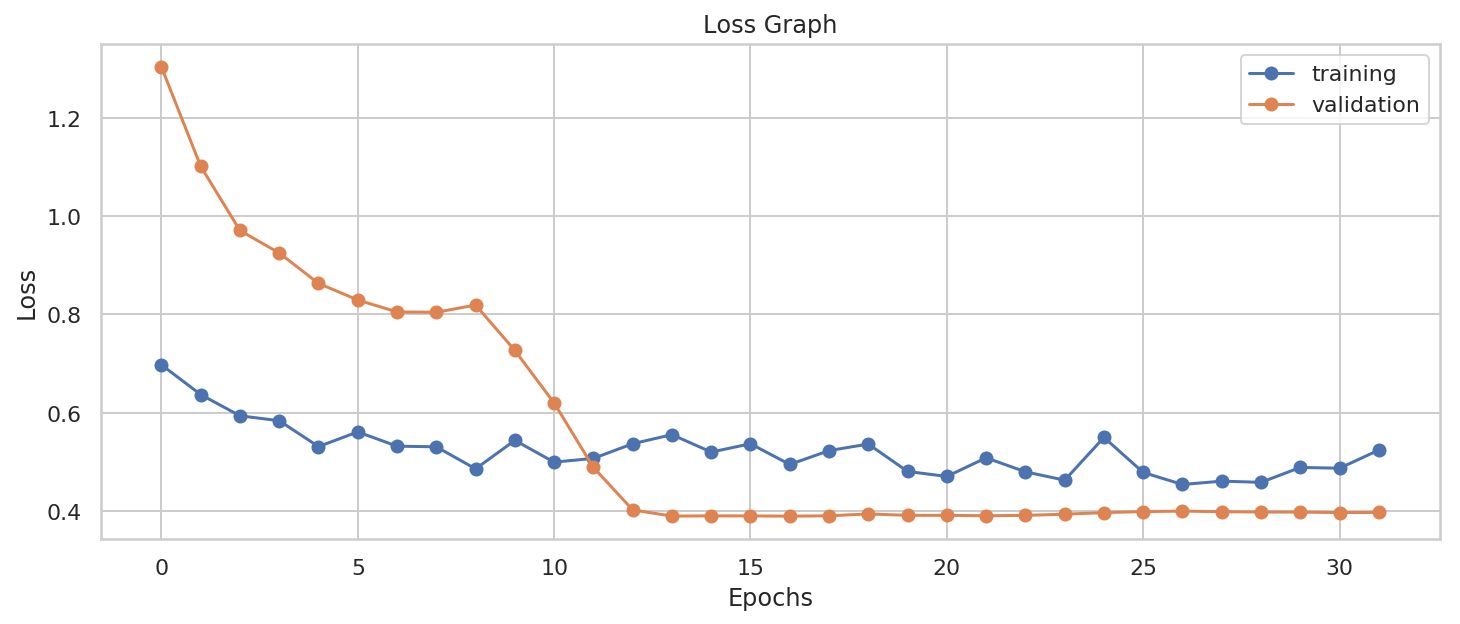

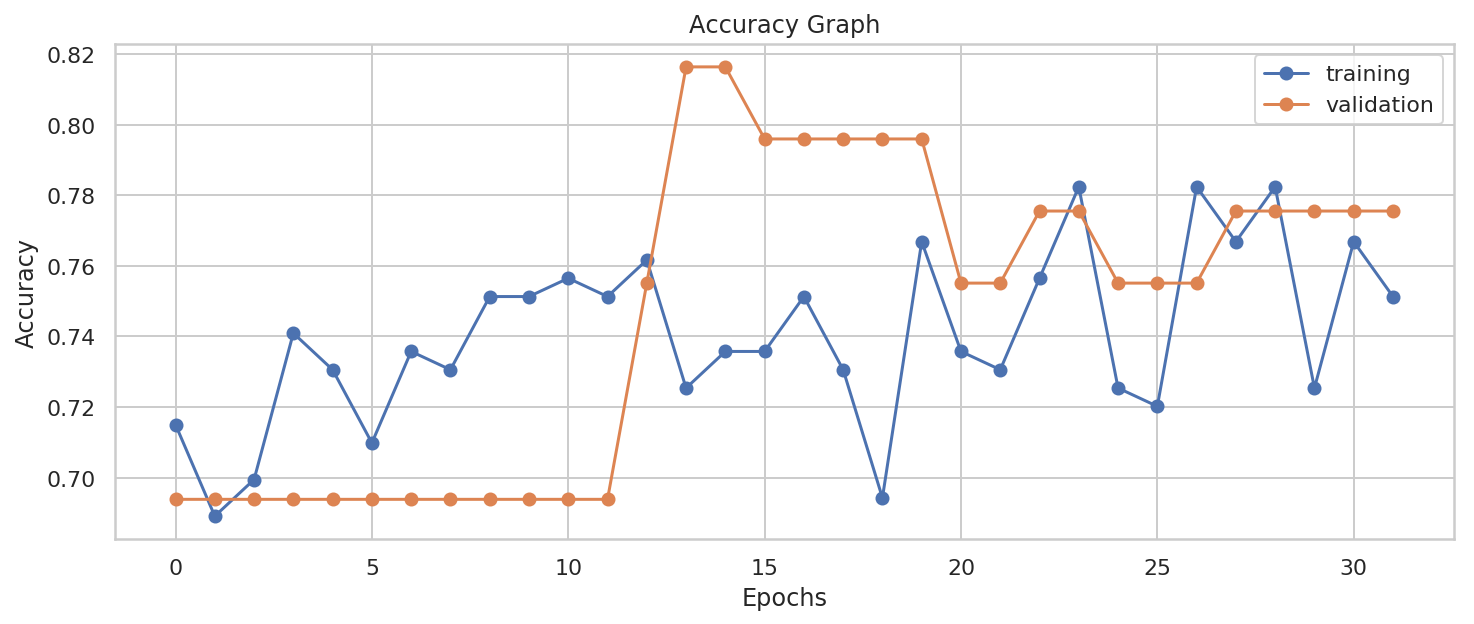

In [58]:
plot(history_df)